<a href="https://colab.research.google.com/github/doissegundos/AlexNet_Cifar10/blob/main/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##AlexNet

### Este projeto desenvolve um algoritmo de rede neural convolucional chamado de AlexNet. O modelo desse algoritmo é dado na imagem abaixo: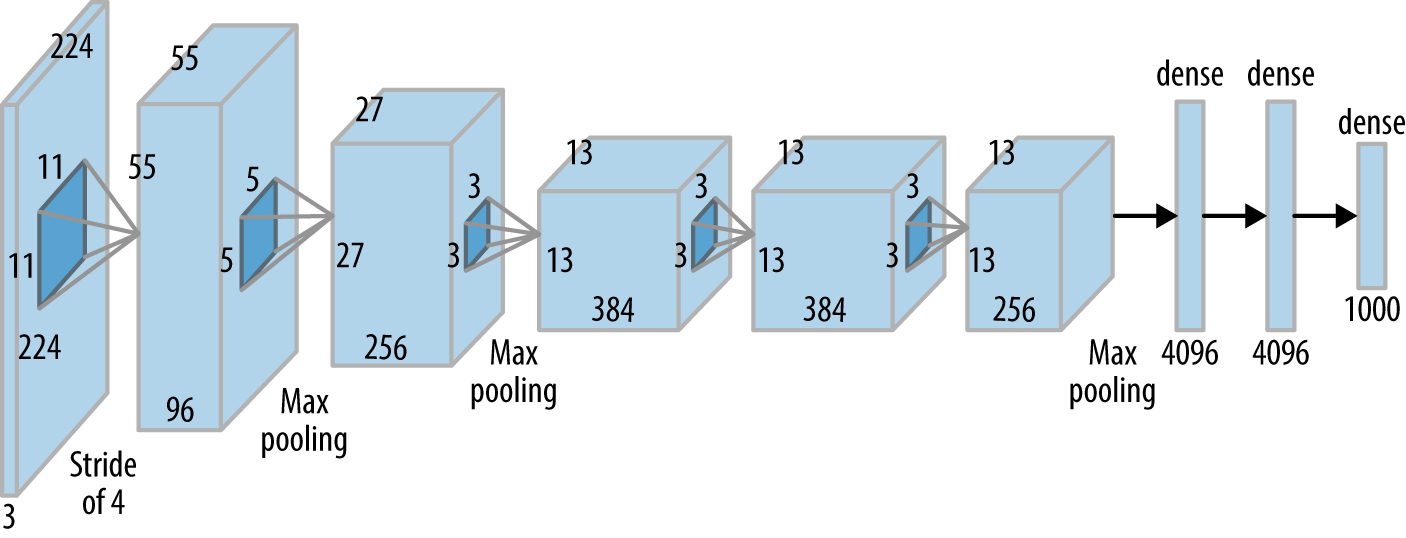

In [ ]:
import tensorflow as tf 
from tensorflow import keras 
import matplotlib.pyplot as plt 
import os 
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.utils import np_utils
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D,Conv2D
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab import drive
from keras.utils import np_utils

In [ ]:
#Para acessar as imagens do Drive
drive.mount('/content/drive')
root_path = "drive/My Drive/dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### O conjunto de dados CIFAR-10 contém 60.000 imagens coloridas, cada uma com dimensões de 32x32px . O conteúdo das imagens no conjunto de dados é uma amostra de 10 classes.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

In [ ]:
train_images = train_images[:10000]
train_labels = train_labels[:10000]

In [ ]:
test_images = test_images[:2000]
test_labels = test_labels[:2000]

#### As classes das imagens do dataset cifar10 são:
- Avião
- Automóvel
- Pássaro
- Gato
- Veado
- Cachorro
- Sapo
- Cavalo
- Navio
- Caminhão

In [ ]:
CLASS_NAMES = ['avião', 'automóvel', 'pássaro', 'gato', 'veado', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']

#### Para o desenvolvimento de uma rede neural, é necessário dividir o dataset em imagens de treinamento, teste e validação. Os dados de treinamento e teste já foram separados, porém ainda deve-se separar os dados de validação, para isso 10% dos dados de treinamento irão ser destinados para a validação do modelo

In [ ]:
train_images, valid_images, train_labels, valid_labels = train_test_split(train_images,train_labels, test_size = 0.1, train_size=0.9)

print('Quantidade de imagens de treinamento:', len(train_images))
print('Quantidade de imagens de teste:', len(test_images))
print('Quantidade de imagens de validação:', len(valid_images))

Quantidade de imagens de treinamento: 9000
Quantidade de imagens de teste: 2000
Quantidade de imagens de validação: 1000


#### Transforma os datasets de treino, validação e teste para o tipo dataset tensorflow, para que assim, eles possam ser enviados para a rede neural

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))

In [ ]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

#### O modelo AlexNet utiliza imagens de entrada com o tamanho 227x227, e as imagens do dataset cifar10 contém imagens do tamanho 32x32, para isso, se faz necessario o uso de uma função para redimencionar as imagens do tamanho 32x32 em 227x227.

In [ ]:
def redimenciona_images(image, label):
    # Normaliza os pixels para ficarem no intervalo entre 0 e 1
    image = tf.image.per_image_standardization(image)
    # Realiza o redimencionamento das imagens
    image = tf.image.resize(image, (227,227))
    return image, label

In [ ]:
train_dataset = (train_dataset
                  .map(redimenciona_images)
                  .shuffle(buffer_size=len(train_dataset))
                  .batch(batch_size=32, drop_remainder=True))
test_dataset = (test_dataset
                  .map(redimenciona_images)
                  .shuffle(buffer_size=len(test_dataset))
                  .batch(batch_size=32, drop_remainder=True))
validation_dataset = (validation_dataset
                  .map(redimenciona_images)
                  .shuffle(buffer_size=len(validation_dataset))
                  .batch(batch_size=32, drop_remainder=True))

In [ ]:
def AlexNet():
  modelo = Sequential()

  modelo.add(Conv2D(filters = 96, kernel_size=(11,11),strides = (4,4), input_shape = (227,227,3), activation='relu'))
  modelo.add(BatchNormalization())
  modelo.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

  modelo.add(Conv2D(filters = 256, kernel_size=(5,5),strides = (1,1), activation='relu', padding="same"))
  modelo.add(BatchNormalization())
  modelo.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

  modelo.add(Conv2D(filters = 384, kernel_size=(3,3),strides = (1,1), activation='relu', padding="same"))
  modelo.add(BatchNormalization())

  modelo.add(Conv2D(filters = 384, kernel_size=(1,1),strides = (1,1), activation='relu', padding="same"))
  modelo.add(BatchNormalization())

  modelo.add(Conv2D(filters = 256, kernel_size=(1,1),strides = (1,1), activation='relu', padding="same"))
  modelo.add(BatchNormalization())
  modelo.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

  modelo.add(Flatten())
  modelo.add(Dense(4096, activation='relu'))
  modelo.add(Dropout(0.5)) 
  modelo.add(Dense(4096, activation='relu'))
  modelo.add(Dropout(0.5))
  modelo.add(Dense(10, activation='softmax'))

  modelo.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
  modelo.summary()

  return modelo

In [ ]:
def treinamento():
  #num_classes = 10
  #label_dataset_train = np_utils.to_categorical(train_labels,num_classes)
  #label_dataset_valid = np_utils.to_categorical(valid_labels,num_classes)  


  checkpoint = ModelCheckpoint(r'drive/My Drive/GAN/teste/40x/test1/modelos/CNNGAN14%d.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)
  early_stop = EarlyStopping(monitor='val_loss',min_delta=0.001,patience=500,mode='min',verbose=1)

  modelo = AlexNet()
  modelo.fit(train_dataset,epochs=200,validation_data=validation_dataset,callbacks=[checkpoint, early_stop])

In [ ]:
treinamento()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8